In [1]:
from mutagene.profiles import Sample
from mutagene.signatures import Identify
import json
import numpy as np
from glob import glob
from subprocess import Popen, PIPE

In [2]:
def get_sub_seq():
    seq = []
    for p5 in "ACGT":
        for p3 in "ACGT":
            for x,y in [('C','A'),('C','G'),('C','T'),('T','A'),('T','C'),('T','G')]:
                seq.append(f"{p5}[{x}>{y}]{p3}")
    return seq

def deconstruct_sigs(profile):
    script1 = """
library(jsonlite)
library(deconstructSigs)
s <- data.frame(t(data.frame(sample=c{})))
colnames(s) <- c{}
w <- whichSignatures(
    tumor.ref = s / sum(s),
    sample.id = 'sample',
    signatures.ref=signatures.cosmic,
    signature.cutoff=0.00)
toJSON(w)
"""
    script2 = script1.format(tuple(profile), tuple(get_sub_seq())).encode("utf-8")

    proc = Popen(["Rscript", "-"], stdin=PIPE, stdout=PIPE, stderr=PIPE)
    out, err = proc.communicate(script2, timeout=10)
    exitcode = proc.returncode
    if exitcode:
        print("Exit code:", exitcode, "Out:", out.decode("utf-8"), "Error:", err.decode("utf-8"), sep="\n\n")
        raise Exception("R error")
    json_string = out.decode("utf-8")
    w = json.loads(json_string)
    # import pprint
    # pprint.pprint(w)
    result = []
    for k, v in w['weights'][0].items():
        if k.startswith('_row'):
            continue
        # if float(v) == 0.0:
        #     continue
        name = k.replace('Signature.', '')
        result.append({
            'name': name,
            'score': v})
    return result

In [3]:
# Find sample files
sample_files = glob('samples/benchmark/*.maf')
list(enumerate(sample_files))

[(0, 'samples/benchmark/tcga_brca.maf'),
 (1, 'samples/benchmark/tcga_dlbc.maf'),
 (2, 'samples/benchmark/tcga_luad.maf'),
 (3, 'samples/benchmark/tcga_skcm.maf')]

In [5]:
# Get samples from multisample file
samples = Sample.multisample(sample_files[0], 'samples/hg38.2bit')

In [ ]:
profs = [s.profile for s in samples]
sel_prof = max(samples, key=lambda s: s.profile)
samples.index(sel_prof)

PROFILE


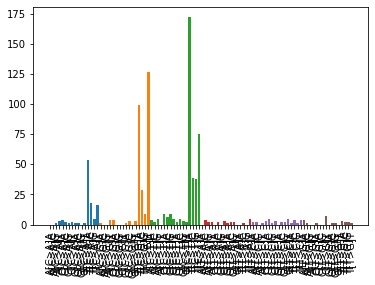

MUTATION COUNT: 848.0
MUTAGENE DECONSTRUCTION
sample	signature	exposure	mutations	exposure_CI_low	exposure_CI_high	mutations_CI_low	mutations_CI_high
VCF	1	0.0284	24	0.0256	0.0311	22	26
VCF	2	0.3433	291	0.3372	0.3494	286	296
VCF	7	0.0448	38	0.0408	0.0488	35	41
VCF	9	0.0205	17	0.0172	0.0238	15	20
VCF	10	0.0297	25	0.0265	0.0328	23	28
VCF	13	0.4146	352	0.4067	0.4224	345	358
VCF	17	0.0153	13	0.0133	0.0172	11	15
VCF	18	0.0085	7	0.0064	0.0106	5	9
VCF	21	0.0049	4	0.0035	0.0063	3	5
DECONSTRUCTSIGS DECONSTRUCTION


[{'name': '1', 'score': 0.0211},
 {'name': '2', 'score': 0.3551},
 {'name': '3', 'score': 0},
 {'name': '4', 'score': 0.0039},
 {'name': '5', 'score': 0.1276},
 {'name': '6', 'score': 0},
 {'name': '7', 'score': 0.0299},
 {'name': '8', 'score': 0},
 {'name': '9', 'score': 0.0067},
 {'name': '10', 'score': 0.035},
 {'name': '11', 'score': 0},
 {'name': '12', 'score': 0},
 {'name': '13', 'score': 0.3836},
 {'name': '14', 'score': 0},
 {'name': '15', 'score': 0},
 {'name': '16', 'score': 0},
 {'name': '17', 'score': 0},
 {'name': '18', 'score': 0.0294},
 {'name': '19', 'score': 0},
 {'name': '20', 'score': 0},
 {'name': '21', 'score': 0},
 {'name': '22', 'score': 0},
 {'name': '23', 'score': 0},
 {'name': '24', 'score': 0.0077},
 {'name': '25', 'score': 0},
 {'name': '26', 'score': 0},
 {'name': '27', 'score': 0},
 {'name': '28', 'score': 0},
 {'name': '29', 'score': 0},
 {'name': '30', 'score': 0}]

In [17]:
sample_id = 400
print("PROFILE")
samples[sample_id].plot_profile()
print("MUTATION COUNT:", sum(samples[sample_id].profile))
print("MUTAGENE DECONSTRUCTION")
Identify(samples[sample_id].profile, 30, bootstrap=True).write_results()
print("DECONSTRUCTSIGS DECONSTRUCTION")
deconstruct_sigs(samples[sample_id].profile)